In [5]:
using Pkg
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("Plots")
Pkg.add("DifferentialEquations")
Pkg.add("Optimization")
Pkg.add("OptimizationOptimJL")
Pkg.add("OptimizationBBO")
Pkg.add("DiffEqParamEstim")
Pkg.add("StatsBase")
Pkg.add("SciMLSensitivity")
Pkg.add("BlackBoxOptim")
Pkg.add("StatsPlots")
Pkg.add("DataFramesMeta")
Pkg.add("Interact")
Pkg.add("Random")
Pkg.add("Distributions")
Pkg.add("LsqFit")
 Pkg.add("RecursiveArrayTools")

   Resolving package versions...
  No Changes to `C:\Users\MainFrameTower\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\MainFrameTower\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\MainFrameTower\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\MainFrameTower\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\MainFrameTower\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\MainFrameTower\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\MainFrameTower\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\MainFrameTower\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\MainFrameTower\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\MainFrameTower\.julia\environments\v1.11\Manifest.toml`
   Resolving package

In [6]:
using Pkg
using Random
using Distributions
using StatsBase
using CSV
using Plots
using DataFrames
using DifferentialEquations
using SciMLSensitivity
using LsqFit
using DifferentialEquations, RecursiveArrayTools, Plots, DiffEqParamEstim
using Optimization, ForwardDiff, OptimizationOptimJL, OptimizationBBO
using BlackBoxOptim
using StatsPlots
using DataFramesMeta
using Printf
using Logging

LoadError: ArgumentError: Package RecursiveArrayTools not found in current path, maybe you meant `import/using .RecursiveArrayTools`.
- Otherwise, run `import Pkg; Pkg.add("RecursiveArrayTools")` to install the RecursiveArrayTools package.

In [ ]:
"""
    setUpProblem(model, xdata, ydata, solver, u0, p, tspan, bounds)

Sets up and solves an ODE fitting problem using BlackBoxOptim.
Returns optimized parameters, solution, and the problem object.
"""
function setUpProblem(model, x, y, solver, u0, p0, tspan, bounds)
    prob = ODEProblem(model, u0, tspan, p0)
    solve(prob, solver, saveat=x, reltol=1e-16, abstol=1e-16)

    loss = build_loss_objective(
        prob, solver,
        L2Loss(x, y),
        Optimization.AutoForwardDiff();
        maxiters=10_000, verbose=false
    )

    result = bboptimize(
        loss;
        SearchRange = collect(zip(first.(bounds), last.(bounds))),
        Method      = :de_rand_1_bin,
        MaxTime     = 100.0,
        TraceMode   = :silent
    )

    p̂      = best_candidate(result)
    prob̂   = ODEProblem(model, [y[1]], tspan, p̂)
    x_dense = range(x[1], x[end], length=1000)
    sol̂    = solve(prob̂, solver, reltol=1e-12, abstol=1e-12, saveat=x_dense)

    return p̂, sol̂, prob̂
end

"""
    calculate_bic(prob, xdata, ydata, solver, params)

Calculates the Bayesian Information Criterion (BIC) and Sum of Squared Residuals (SSR) for a solved ODE model.
"""
function calculate_bic(prob, x, y, solver, p)
    sol = solve(prob, solver, reltol=1e-15, abstol=1e-15, saveat=x)
    resid = y .- getindex.(sol.u, 1)
    ssr   = sum(resid .^ 2)
    k     = length(p)
    n     = length(x)
    bic   = n * log(ssr / n) + k * log(n)
    bic, ssr
end

"""
    pQuickStat(x, y, optimized_params, optimized_sol, optimized_prob, bic, ssr)

Displays a plot of model fit and prints model parameters, BIC, and SSR.
"""
function pQuickStat(x, y, p, sol, prob, bic, ssr)
    println("→ Optimized params: ", p)
    println("→ SSR: ", ssr)
    println("→ BIC: ", bic)

    plt = scatter(x, y;
        label   = "Data",
        legend  = :bottomright,
        xlabel  = "Day",
        ylabel  = "Average",
        title   = "Model Fit"
    )
    plot!(plt, sol.t, getindex.(sol.u,1); label="Model", lw=2)
    display(plt)
end



function run_single_fit(
    df::DataFrame,
    p0::Vector{<:Real};
    cell_size,
    model         = logistic!,
    fixed_params  = nothing,
    solver        = Rodas5(),
    bounds        = nothing,
    show_stats::Bool = true, 
)
    # wrap for fixed_params
    if fixed_params !== nothing
        old_model = model
        model = (du,u,p,t) -> old_model(du, u, vcat(p, fixed_params), t)
    end

    nparams = length(p0)
    bounds === nothing && (bounds = [(0.0, Inf) for _ in 1:nparams])

    x, y = extract_day_averages_from_df(df)
    tspan  = (x[1], x[end])
    u0     = [y[1]]

    p̂, sol̂, prob̂ = setUpProblem(model, x, y, solver, u0, p0, tspan, bounds)
    bic, ssr       = calculate_bic(prob̂, x, y, solver, p̂)
    show_stats && pQuickStat(x, y, p̂, sol̂, prob̂, bic, ssr)

    return (params = p̂, bic = bic, ssr = ssr, sol = sol̂)
end

These are all imported functions from my Summer '25 Analysis notebook

In [3]:
function load_csv_files_with_logging(file_list::Vector{String}, data_path::String)
    loaded_data = Dict{String, DataFrame}()
    failed_files = Dict{String, String}()

    for file in file_list
        try
            df = CSV.read(data_path * file, DataFrame)
            loaded_data[file] = df
            #println("✅ Loaded: ", file)
        catch e
            println("❌ Failed to load: $file")
            println("   ↳ Error: ", e.msg)
            push!(failed_files, file => e.msg)
        end
    end

    println("\n📊 Summary")
    println("  ✔️ Success: ", length(loaded_data))
    println("  ❌ Failed: ", length(failed_files))

    #if !isempty(failed_files)
        #println("\nFailed files:")
        #for (f, err) in failed_files
            #println("  - $f → $err")
        #end
    #end

    return loaded_data
end


# Path to the folder
data_path = "RealData/"

# List of your files (from your screenshot)
files = [
    "cellSizeNaive.csv",
    "cellSizeResistant.csv",
    "A25-75_A2780_RCo.csv",
    "B25-75_A2780_Co.csv",
    "C2780_R.csv",
    "D50-50_A2780_RCo.csv",
    "E50-50_A2780_Co.csv",
    "F75-25_A2780_RCo.csv",
    "G75-25_A2780_Co.csv",
    "H2780.csv",
    "Resistant.csv",
    "ResistantT.csv",
    "Naive.csv",
    "NaiveT.csv"
]


# Load the files
datasets = load_csv_files_with_logging(files, data_path)
xy_data = Dict{String, Tuple{Vector{Float64}, Vector{Float64}}}()



📊 Summary
  ✔️ Success: 14
  ❌ Failed: 0


Dict{String, Tuple{Vector{Float64}, Vector{Float64}}}()

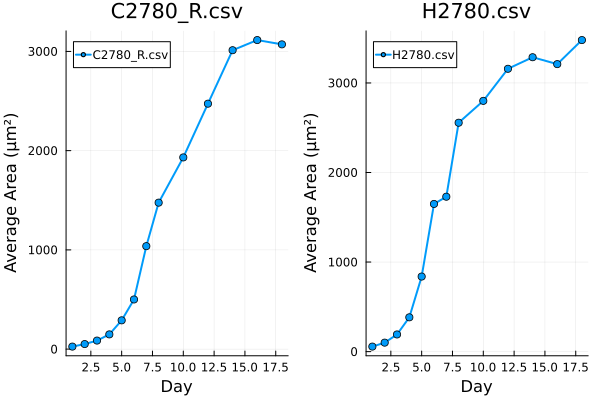


📊 Running logistic model for: C2780_R

Optimized Parameters:
[0.6326442983105124, 3017.762997635546]

Sum of Squared Residuals (SSR):
4.512149414414315e10

Bayesian Information Criterion (BIC):
290.7096763282244


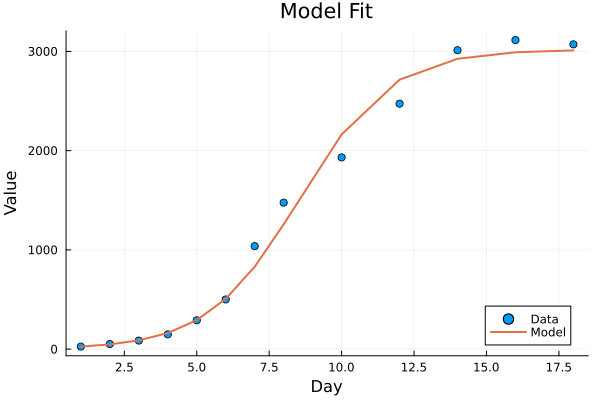


📊 Running logistic model for: H2780

Optimized Parameters:
[0.7402835619772713, 3255.8396418522248]

Sum of Squared Residuals (SSR):
5.481877034720294e7

Bayesian Information Criterion (BIC):
203.43961890002623


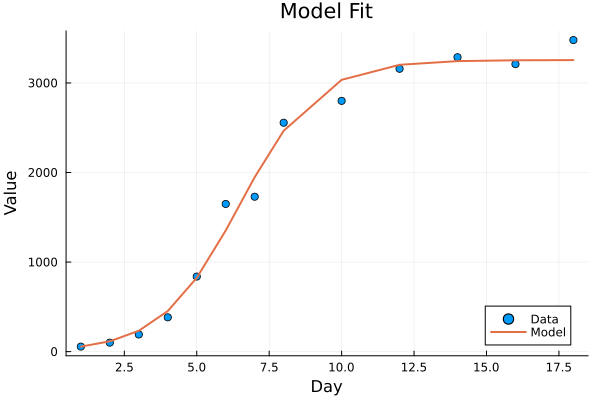

2-element Vector{Float64}:
    0.7402835619772713
 3255.8396418522248

In [4]:
# Make sure `datasets` is already loaded using your function
# datasets = load_csv_files_with_logging(...)
function setUpProblem(modelTypeSet, xdataSet, ydataSet, solverSet, u0Set, pSet, tspanSet, boundsSet)
    best_params, best_sol, best_prob, best_loss = nothing, nothing, nothing, Inf

    for _ in 1:5
        p_init = [lo[1] == lo[2] ? lo[1] : rand(Uniform(lo[1], lo[2])) for lo in boundsSet]

        try
            prob = ODEProblem(modelTypeSet, u0Set, tspanSet, p_init)
            loss_func = build_loss_objective(prob, solverSet, L2Loss(xdataSet, ydataSet), Optimization.AutoForwardDiff())
            result = bboptimize(loss_func; SearchRange=boundsSet, MaxTime=30.0, TraceMode=:silent)
            p_opt = best_candidate(result)
            sol = solve(remake(prob, p=p_opt), solverSet, saveat=xdataSet)
            loss = sum(abs2.(ydataSet .- [u[1] for u in sol.u]))

            if loss < best_loss
                best_params, best_sol, best_prob, best_loss = p_opt, sol, prob, loss
            end
        catch; end
    end

    return best_params, best_sol, best_prob
end

function extract_day_averages_from_df(df::DataFrame)
    df = filter(row -> occursin(r"_Tile-\d+_[^AC]\d", row.Image), df)

    # Extract day from image name
    function extract_day(name::AbstractString)
        m = match(r"(?i)day(\d+)", name)
        return m !== nothing ? parse(Int, m.captures[1]) : missing
    end
    df.day = extract_day.(df.Image)
    df = dropmissing(df, :day)

    # Group by day and average every 18 tiles
    grouped = groupby(df, :day)
    new_rows = []

    for g in grouped
        chunked = [g[i:min(i+17, nrow(g)), :] for i in 1:18:nrow(g)]
        for chunk in chunked
            avg = mean(chunk[!, Symbol("Area µm^2")])
            push!(new_rows, (Day = unique(chunk.day)[1], Average = avg))
        end
    end

    return DataFrame(new_rows)
end

function build_plot_from_dataset_key(dataset_key::String; label_name::String = dataset_key)
    if !haskey(datasets, dataset_key)
        println("❌ Dataset not found: $dataset_key")
        return nothing
    end

    df_raw = datasets[dataset_key]
    df_avg = extract_day_averages_from_df(df_raw)

    x = Float64[]
    y = Float64[]

    for row in eachrow(df_avg)
        push!(x, Float64(row.Day))
        push!(y, Float64(row.Average)/157.7)
    end

    return plot(x, y,
                label=label_name,
                xlabel="Day",
                ylabel="Average Area (µm²)",
                marker=:circle,
                linewidth=2,
                title=label_name), x, y
end

# Plotting multiple files
plots = []
xy_data = Dict{String, Tuple{Vector{Float64}, Vector{Float64}}}()
treatment = ["C2780_R.csv", "H2780.csv"]

for file in treatment
    plot_obj, x, y = build_plot_from_dataset_key(file)
    if plot_obj !== nothing
        push!(plots, plot_obj)
        xy_data[file] = (x, y)
    end
end

# Show all in grid
display(plot(plots..., layout=(ceil(Int, length(plots)/2), 2)))

#This will get the parameters for the untreated varieties
# Define the logistic growth model
function logistic_growth!(du, u, p, t)
    r, K = p
    du[1] = r * u[1] * (1 - u[1] / K)
end

# Model fitting for each dataset
function run_logistic_fit(file::String, cap::Int)
    label = replace(file, ".csv" => "")
    println("\n📊 Running logistic model for: $label")

    # Build x/y if missing
    if !haskey(xy_data, file)
        plot_obj, x, y = build_plot_from_dataset_key(file)
        if plot_obj !== nothing
            xy_data[file] = (x, y)
        else
            error("❌ Could not extract data from $file.")
        end
    end

    # Use x and y
    x, y = xy_data[file]

    # Initial parameters and solver
    solver = Rodas5()
    tspan = (x[1], x[end])
    u0 = [y[1]]
    p = [0.5, cap]
    bounds = [(0.0, 1.5), (100.0, 100000.0)]  # r, K bounds

    # Fit logistic model
    optimized_params, optimized_sol, optimized_prob = setUpProblem(
        logistic_growth!, x, y, solver, u0, p, tspan, bounds
    )

    # Metrics
    bic, ssr = calculate_bic(optimized_prob, x, y, solver, optimized_params)

    # Display stats + plot
    pQuickStat(x, y, optimized_params, optimized_sol, optimized_prob, bic, ssr)

    return optimized_params
end

#implementation

params_naive = run_logistic_fit("C2780_R.csv", 25000)
params_resist = run_logistic_fit("H2780.csv", 25000)

r_naive, K_naive = params_naive
r_resist, K_resist = params_resist


📂 Saved keys in xy_data:
   • coculture_F75-25_A2780_RCo.csv
   • H2780.csv
   • coculture_B25-75_A2780_Co.csv
   • coculture_E50-50_A2780_Co.csv
   • coculture_G75-25_A2780_Co.csv
   • coculture_A25-75_A2780_RCo.csv
   • coculture_D50-50_A2780_RCo.csv
   • C2780_R.csv


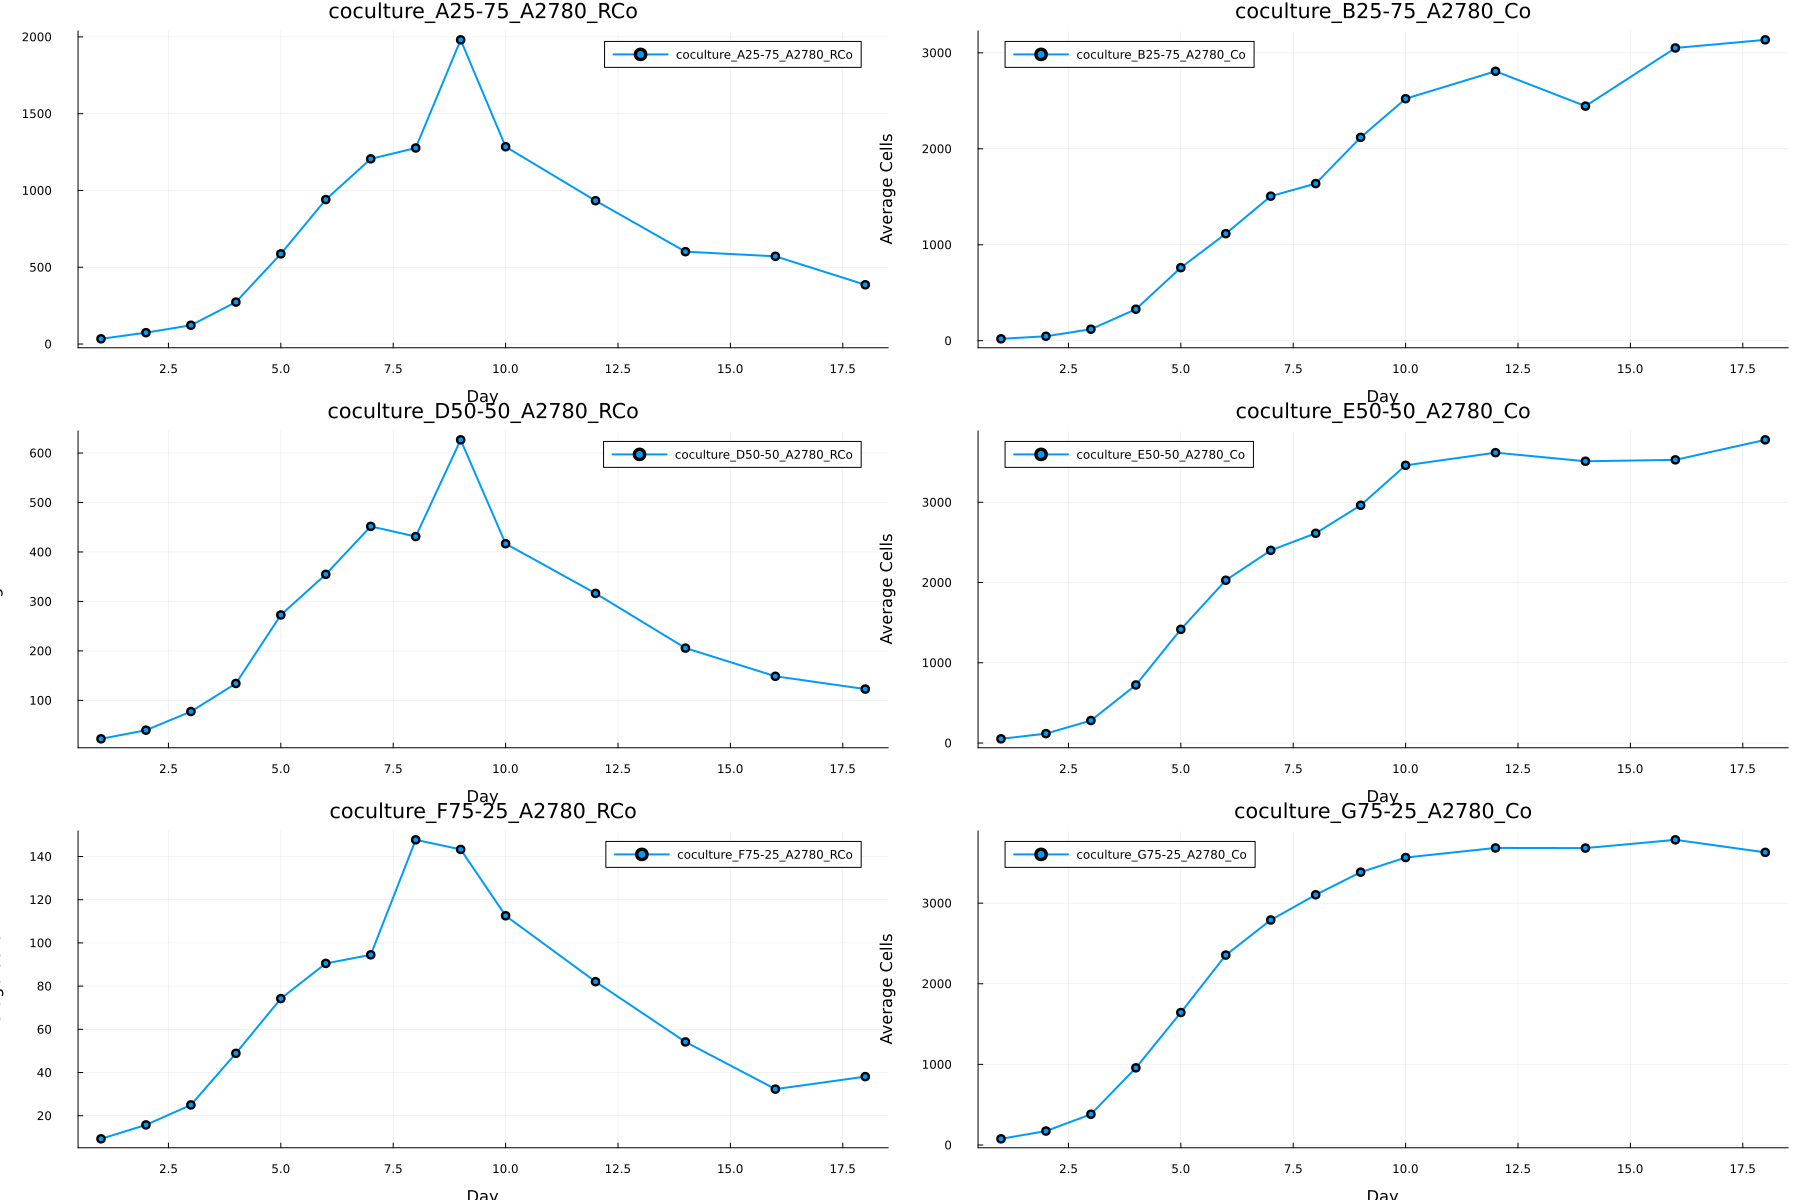

In [5]:
# Updated extractor that skips images ending in _(letter)(1|2|3)
function extract_day_averages_exclude_special(df::DataFrame; debug=true)
    #println("🔍 Starting image filter...")

    # Step 1: Debug how many rows would be excluded
    bad_rows = filter(row -> occursin(r"_.*[123]\.tif$", row.Image), df)
    #if debug
        #println("⚠️ Matched rows ending in _(letter)(1|2|3): ", nrow(bad_rows))
        #if nrow(bad_rows) > 0
            #println("   ↳ Examples:")
            #println.(bad_rows[1:min(5, nrow(bad_rows)), :Image])
        #end
    #end

    # Step 2: Remove bad rows
    df = filter(row -> !occursin(r"_.*[123]\.tif$", row.Image), df)

    # Step 3: Extract day from image names
    function extract_day(name::AbstractString)
        m = match(r"(?i)day(\d+)", name)
        return m !== nothing ? parse(Int, m.captures[1]) : missing
    end

    df.day = extract_day.(df.Image)
    df = dropmissing(df, :day)

    # Step 4: Group and average every 18 tiles per day
    grouped = groupby(df, :day)
    new_rows = []

    for g in grouped
        chunked = [g[i:min(i+17, nrow(g)), :] for i in 1:18:nrow(g)]
        for chunk in chunked
            avg = mean(chunk[!, Symbol("Area µm^2")])
            push!(new_rows, (Day = unique(chunk.day)[1], Average = avg))
        end
    end

    df_avg = DataFrame(new_rows)

    # Step 5: Debug duplicate day values
    if debug
        #println("✅ Finished averaging. Preview:")
        #println(first(df_avg, min(5, nrow(df_avg))))
        day_counts = countmap(df_avg.Day)
        dups = filter(x -> x[2] > 1, collect(day_counts))
        if !isempty(dups)
            #println("⚠️ Duplicate day values found in averaged data:")
            for (day, count) in dups
                println("   Day $day appears $count times.")
            end
        end
    end

    return df_avg
end



# Plot builder using the updated extractor
function build_coculture_plot_from_key(dataset_key::String; label_prefix="coculture_")
    if !haskey(datasets, dataset_key)
        println("❌ Dataset not found: $dataset_key")
        return nothing
    end

    df_raw = datasets[dataset_key]
    df_avg = extract_day_averages_exclude_special(df_raw; debug=true)

    x = Float64[]
    y = Float64[]

    for row in eachrow(df_avg)
        push!(x, Float64(row.Day))
        push!(y, Float64(row.Average) / 157.7)  # Optional scaling
    end

    label_name = label_prefix * replace(dataset_key, ".csv" => "")
    return plot(x, y,
                label=label_name,
                xlabel="Day",
                ylabel="Average Cells",
                marker=:circle,
                linewidth=2,
                title=label_name), x, y
end

# Coculture files
coculture_files = [
    "A25-75_A2780_RCo.csv",
    "B25-75_A2780_Co.csv",
    "D50-50_A2780_RCo.csv",
    "E50-50_A2780_Co.csv", 
    "F75-25_A2780_RCo.csv",
    "G75-25_A2780_Co.csv"
]

# Create plots and store xy_data with "coculture_" prefix
coculture_plots = []
for file in coculture_files
    plot_obj, x, y = build_coculture_plot_from_key(file)
    if plot_obj !== nothing
        push!(coculture_plots, plot_obj)
        xy_data["coculture_$file"] = (x, y)
    end
end

# ✅ Print saved keys
println("📂 Saved keys in xy_data:")
for key in keys(xy_data)
    println("   • $key")
end

# Display all coculture plots
display(plot(coculture_plots..., layout=(ceil(Int, length(coculture_plots)/2), 2), size=(1800, 1200)))


✅ Removed day 9 from coculture_A25-75_A2780_RCo.csv
✅ Removed day 9 from coculture_D50-50_A2780_RCo.csv
✅ Removed day 9 from coculture_F75-25_A2780_RCo.csv
💾 Stored combined data as key: combined_BA_25-75


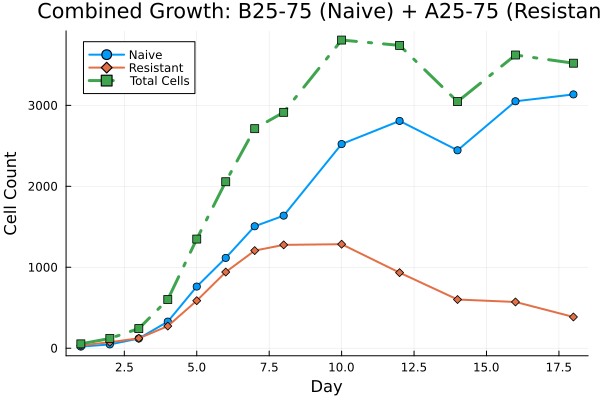

💾 Stored combined data as key: combined_ED_50-50


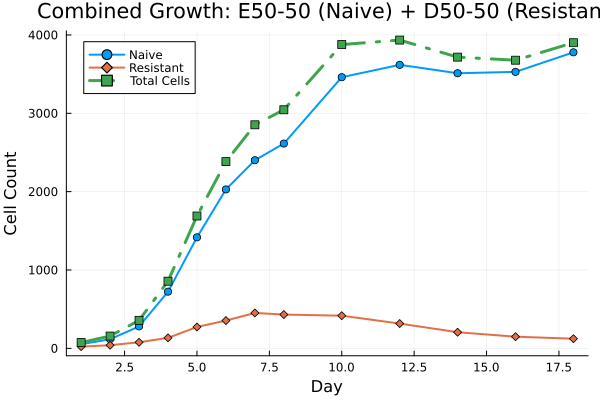

💾 Stored combined data as key: combined_GF_75-25


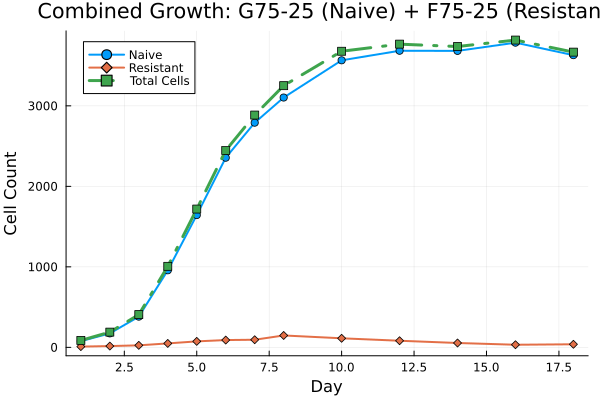


🔑 Final combined keys saved:
   • combined_GF_75-25
   • combined_BA_25-75
   • combined_ED_50-50


In [6]:
function plot_combined_naive_resist(naive_key::String, resist_key::String; combined_label="Total Cells")
    # Check that both datasets exist
    if !haskey(xy_data, naive_key)
        println("❌ Missing naive dataset: $naive_key")
        return
    end
    if !haskey(xy_data, resist_key)
        println("❌ Missing resistant dataset: $resist_key")
        return
    end

    # Extract data
    x_naive, y_naive = xy_data[naive_key]
    x_resist, y_resist = xy_data[resist_key]

    # Match by overlapping days
    common_days = intersect(x_naive, x_resist)
    if isempty(common_days)
        println("⚠️ No overlapping days between $naive_key and $resist_key")
        return
    end

    # 1) Compute the sorted intersection
    common_days = sort(intersect(x_naive, x_resist))

    # 2) Find indices in each series
    idx_naive  = findall(d -> d in common_days, x_naive)
    idx_resist = findall(d -> d in common_days, x_resist)

    # 3) Pull out the aligned y-values
    yN = y_naive[idx_naive]
    yR = y_resist[idx_resist]

    # 4) Now x_common is exactly the sorted days
    x_common = common_days

    # 5) Total
    y_total = yN .+ yR


    # Generate a clean title from file names
    function prettify(label)
        label = replace(label, r"coculture_" => "")
        label = replace(label, r"_A2780.*" => "")
        return label
    end
    title_str = "Combined Growth: " * prettify(naive_key) * " (Naive) + " * prettify(resist_key) * " (Resistant)"

    # Build plot
    p = plot(x_common, yN, label="Naive", lw=2, marker=:circle)
    plot!(p, x_common, yR, label="Resistant", lw=2, marker=:diamond)
    plot!(p, x_common, y_total, label=combined_label, lw=3, linestyle=:dashdot, marker=:square)

    xlabel!("Day")
    ylabel!("Cell Count")
    title!(title_str)
    
    function extract_ratio(fname)
        m = match(r"(\d{2}-\d{2})", fname)
        return m !== nothing ? m.match : "unknown"
    end
    function extract_label(fname)
        m = match(r"coculture_([A-Z])", fname)
        return m !== nothing ? m.captures[1] : "X"
    end

    ratio = extract_ratio(naive_key)
    n_label = extract_label(naive_key)
    r_label = extract_label(resist_key)
    combined_key = "combined_$(n_label)$(r_label)_$ratio"

    xy_data[combined_key] = (x_common, y_total)
    println("💾 Stored combined data as key: $combined_key")

    return p
end

# Plot combinations
function safe_plot_combined(n_key, r_key)
    if haskey(xy_data, n_key) && haskey(xy_data, r_key)
        p = plot_combined_naive_resist(n_key, r_key)
        display(p)
    else
        println("⚠️ Skipping: $n_key or $r_key not found.")
    end
end

# ————— Remove day-9 outliers from each resistant dataset —————
for resist_key in [
      "coculture_A25-75_A2780_RCo.csv",
      "coculture_D50-50_A2780_RCo.csv",
      "coculture_F75-25_A2780_RCo.csv"
    ]
    if haskey(xy_data, resist_key)
        xs, ys = xy_data[resist_key]
        # build a mask that keeps only days ≠ 9
        keep = xs .!= 9
        xy_data[resist_key] = (xs[keep], ys[keep])
        println("✅ Removed day 9 from $resist_key")
    else
        println("⚠️ Resistant key not found: $resist_key")
    end
end

# Now you can re-run your plot_combined_naive_resist(...) calls


safe_plot_combined("coculture_B25-75_A2780_Co.csv", "coculture_A25-75_A2780_RCo.csv")
safe_plot_combined("coculture_E50-50_A2780_Co.csv", "coculture_D50-50_A2780_RCo.csv")
safe_plot_combined("coculture_G75-25_A2780_Co.csv", "coculture_F75-25_A2780_RCo.csv")

# Print final combined keys
println("\n🔑 Final combined keys saved:")
for key in keys(xy_data)
    if startswith(key, "combined_")
        println("   • $key")
    end
end

In [7]:
using DifferentialEquations, Distributions, Random, ForwardDiff, Plots
using Optimization, OptimizationOptimJL

# --- Utility plotting function ---
function plot_coculture_with_true_components(sol, ck, nk, rk, xy_data, title_str)
    # Extract true and predicted values
    xN, yN = xy_data[nk]
    xR, yR = xy_data[rk]
    t = sol.t
    Ns = getindex.(sol.u,1)
    Rs = getindex.(sol.u,2)
    # Plot modeled vs data
    plt = plot(t, Ns, label="Model Naive")
    plot!(plt, t, Rs, label="Model Resistant")
    scatter!(plt, xN, yN, label="Data Naive", marker=:circle)
    scatter!(plt, xR, yR, label="Data Resistant", marker=:star)
    title!(plt, title_str)
    xlabel!(plt, "Time (days)")
    ylabel!(plt, "Cell Count")
    display(plt)
end

# --- 0) Check that logistic parameters and data are defined ---
# Ensure you have defined:
#   r_naive, K_naive, r_resist, K_resist
#   xy_data::Dict{String, Tuple{Vector{<:Real}, Vector{<:Real>}}
println("✅ Logistic params: naive=(r=$(r_naive),K=$(K_naive))  resist=(r=$(r_resist),K=$(K_resist))")

# --- Initialize storage and keys ---
gated_model_results = Dict{String, Any}()
combined_keys = filter(k -> startswith(k, "combined_"), keys(xy_data))

# --- 1) Align two series on common days ---
function to_days_NR(xN, yN, xR, yR)
    days = sort(intersect(xN, xR))
    idxN = findall(d -> d in days, xN)
    idxR = findall(d -> d in days, xR)
    return days, yN[idxN], yR[idxR]
end

# --- 2) Guess initial conditions from filename ratio ---
function guess_initial_conditions(file::String, y)
    base = first(y)
    if occursin("25-75", file)
        return [0.25*base, 0.75*base]
    elseif occursin("50-50", file)
        return [0.5*base, 0.5*base]
    elseif occursin("75-25", file)
        return [0.75*base, 0.25*base]
    else
        @warn "Unknown ratio in $file; defaulting to 50/50"
        return [base/2, base/2]
    end
end

# --- 3) Multi-trial fitter minimizing SSE(N)+SSE(R) ---
function attempt_fit_multi!(model, days, yN, yR, solver, u0, tspan, bounds; trials::Int=8)
    best_loss = Inf
    best_p    = nothing
    best_sol  = nothing
    for i in 1:trials
        α0 = rand(Uniform(bounds[5]...))
        β0 = rand(Uniform(bounds[6]...))
        if length(bounds) == 8
            n0  = rand(Uniform(bounds[7]...))
            th0 = rand(Uniform(bounds[8]...))
            p0 = vcat(getindex.(bounds[1:4],1), α0, β0, n0, th0)
        else
            p0 = vcat(getindex.(bounds[1:4],1), α0, β0)
        end

        sol = solve(ODEProblem(model, u0, tspan, p0), solver; saveat=days, reltol=1e-8, abstol=1e-8)
        Np = getindex.(sol.u, 1)
        Rp = getindex.(sol.u, 2)
        loss = sum(abs2.(Np .- yN)) + sum(abs2.(Rp .- yR))
        if loss < best_loss
            best_loss, best_p, best_sol = loss, copy(p0), sol
        end
    end
    return best_p, best_sol, best_loss
end

# --- 4) Step-gated model fitter ---
function fit_step_model(xN, yN, xR, yR, file, solver, rN, KN, rR, KR)
    days, yNa, yRa = to_days_NR(xN, yN, xR, yR)
    u0 = vcat(guess_initial_conditions(file, yNa), 0.0)
    tspan = (first(days), last(days))
    model = function(du, u, p, t)
        N, R, _ = u
        r_N, K_N, r_R, K_R, α, β = p
        tval = ForwardDiff.value(t)
        βeff = tval > 5 ? β : 0.0
        du[1] = r_N * N * (1 - (N + α*R) / K_N)
        du[2] = r_R * R * (1 - (R + βeff*N) / K_R)
        du[3] = du[1] + du[2]
    end
    bounds = [(rN,rN), (KN,KN), (rR,rR), (KR,KR), (0.0,10.0), (0.0,10.0)]
    return attempt_fit_multi!(model, days, yNa, yRa, solver, u0, tspan, bounds)
end

# --- 5) Hill-gated model fitter ---
function fit_hill_model(xN, yN, xR, yR, file, solver, rN, KN, rR, KR)
    days, yNa, yRa = to_days_NR(xN, yN, xR, yR)
    u0 = vcat(guess_initial_conditions(file, yNa), 0.0)
    tspan = (first(days), last(days))
    model = function(du, u, p, t)
        N, R, _ = u
        r_N, K_N, r_R, K_R, α, β, n, th = p
        tval = ForwardDiff.value(t)
        βeff = β * tval^n / (th^n + tval^n)
        du[1] = r_N * N * (1 - (N + α*R) / K_N)
        du[2] = r_R * R * (1 - (R + βeff*N) / K_R)
        du[3] = du[1] + du[2]
    end
    bounds = [(rN,rN), (KN,KN), (rR,rR), (KR,KR),
              (0.0,10.0), (0.0,10.0), (1.0,6.0), (2.0,10.0)]
    return attempt_fit_multi!(model, days, yNa, yRa, solver, u0, tspan, bounds)
end

# --- 6) Regex key lookup ---
function find_key_regex(r::Regex, dict::Dict{String,Any})
    for k in keys(dict)
        occursin(r, k) && return k
    end
    error("⬜ No key matching: $r")
end

# --- 7) Fit each combined key with logging ---
for ck in combined_keys
    m = match(r"combined_([A-Z])([A-Z])_(\d\d-\d\d)", ck)
    if m === nothing
        @warn "Invalid combined key: $ck"
        continue
    end
    n_lbl, r_lbl, ratio = m.captures
    reN = Regex("coculture_$(n_lbl)$(ratio)_A2780_Co\\.csv")
    reR = Regex("coculture_$(r_lbl)$(ratio)_A2780_RCo\\.csv")
    naive_key  = find_key_regex(reN, xy_data)
    resist_key = find_key_regex(reR, xy_data)
    xN, yN = xy_data[naive_key]
    xR, yR = xy_data[resist_key]
    solver = Rodas5()

    p_s, sol_s, loss_s = fit_step_model(xN, yN, xR, yR, ck, solver, r_naive, K_naive, r_resist, K_resist)
    p_h, sol_h, loss_h = fit_hill_model(xN, yN, xR, yR, ck, solver, r_naive, K_naive, r_resist, K_resist)

    gated_model_results[ck] = (
        step = (params=p_s, sol=sol_s, loss=loss_s),
        hill = (params=p_h, sol=sol_h, loss=loss_h)
    )
    println("🔹 $ck | step loss=$(round(loss_s; digits=2)), hill loss=$(round(loss_h; digits=2))")
end

# --- 8) Plot fitted dynamics ---
for (ck, res) in gated_model_results
    m = match(r"combined_([A-Z])([A-Z])_(\d\d-\d\d)", ck)
    n_lbl, r_lbl, ratio = m.captures
    reN = Regex("coculture_$(n_lbl)$(ratio)_A2780_Co\\.csv")
    reR = Regex("coculture_$(r_lbl)$(ratio)_A2780_RCo\\.csv")
    nk = find_key_regex(reN, xy_data)
    rk = find_key_regex(reR, xy_data)

    plot_coculture_with_true_components(res.step.sol, ck, nk, rk, xy_data, "\$ck Step")
    plot_coculture_with_true_components(res.hill.sol, ck, nk, rk, xy_data, "\$ck Hill")
end


✅ Logistic params: naive=(r=0.6326442983105124,K=3017.762997635546)  resist=(r=0.7402835619772713,K=3255.8396418522248)


LoadError: MethodError: no method matching find_key_regex(::Regex, ::Dict{String, Tuple{Vector{Float64}, Vector{Float64}}})

[0mClosest candidates are:
[0m  find_key_regex(::Regex, [91m::Dict{String, Any}[39m)
[0m[90m   @[39m [35mMain[39m [90m[4mIn[7]:121[24m[39m



📊 BIC Comparison for A2780IC50.csv:


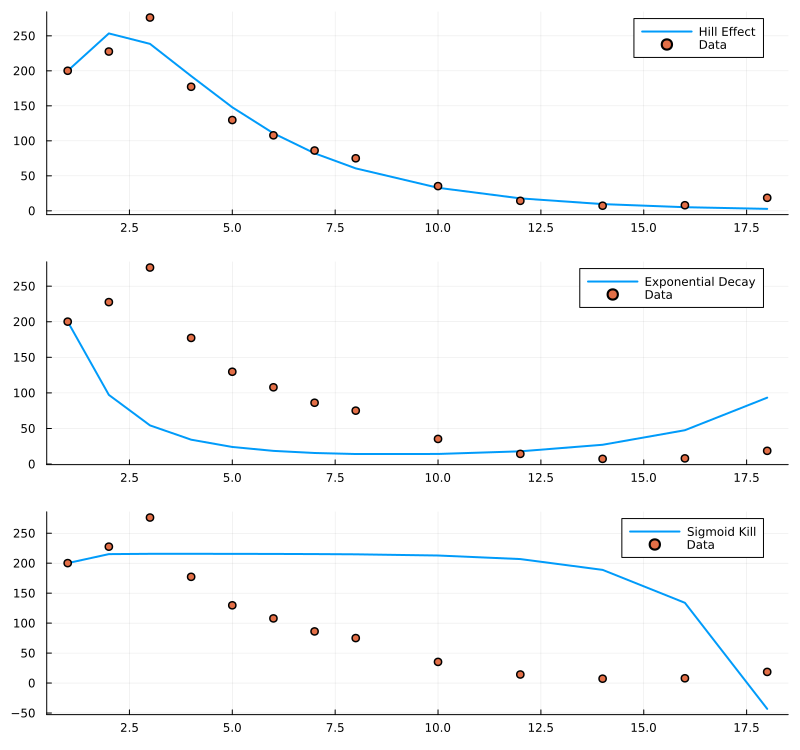

 • Hill Effect: BIC=84.25, params=[0.633, 3017.763, 4496.694, 2.63, 1.832]
 • Exponential Decay: BIC=129.22, params=[0.633, 3017.763, 7341.879, 10.0]
 • Sigmoid Kill: BIC=136.91, params=[0.633, 3017.763, 126.748, 6.0, 1.0]

📊 BIC Comparison for A2780cisIC50.csv:


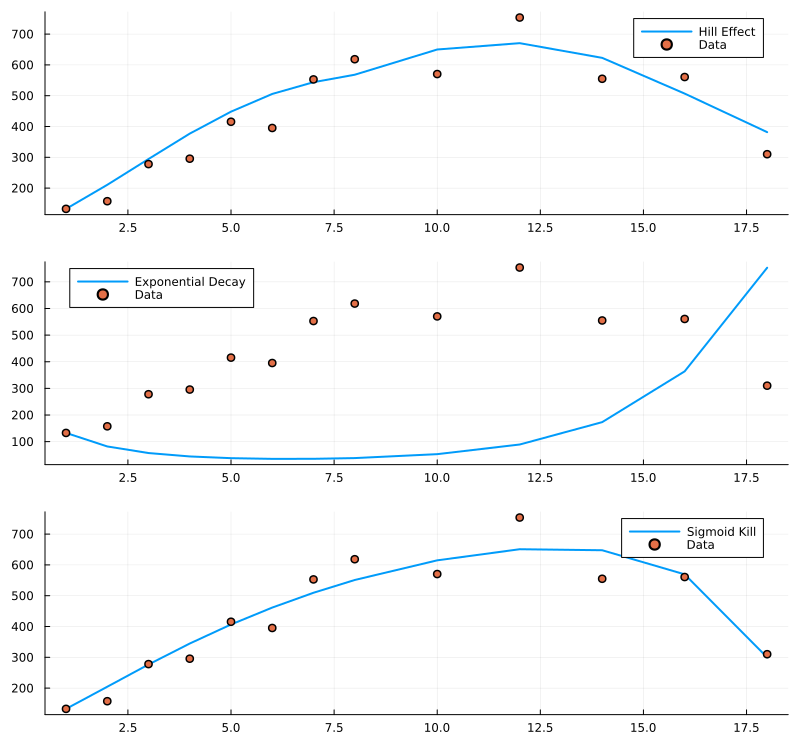

 • Sigmoid Kill: BIC=116.17, params=[0.74, 3255.84, 519.753, 1.584, 6.553]
 • Hill Effect: BIC=120.53, params=[0.74, 3255.84, 3349.494, 1.136, 2.891]
 • Exponential Decay: BIC=166.06, params=[0.74, 3255.84, 6123.278, 10.0]


In [8]:
using Logging
using CSV, DataFrames, Statistics
using DifferentialEquations, Distributions, Random, ForwardDiff, Plots
using Optimization, OptimizationOptimJL
using DiffEqFlux
using BlackBoxOptim

# Suppress all warnings (including SciMLBase dt-forced warnings)
global_logger(SimpleLogger(stderr, Logging.Error))

# -----------------------------
# 🔬 Models
# -----------------------------
global drug_model_results = Dict{String, NamedTuple}()

function logistic!(du, u, p, t)
    r, K = p
    du[1] = r * u[1] * (1 - u[1] / K)
end

function hill_effect!(du, u, p, t)
    N = u[1]
    r, K, γ, n, t_half = p
    t_val = ForwardDiff.value(t)
    effect = γ * (t_val^n) / (t_val^n + t_half^n + 1e-9)
    du[1] = r * N * (1 - (N + effect) / K)
end

function exp_decay_effect!(du, u, p, t)
    N = u[1]
    r, K, γ, τ = p
    decay = γ * exp(-t / τ)
    du[1] = r * N * (1 - (N + decay) / K)
end

function subtractive_sigmoid_kill!(du, u, p, t)
    N = u[1]
    r, K, γ, n, t_half = p
    kill = γ * (t^n / (t^n + t_half^n + 1e-9))
    du[1] = r * N * (1 - N / K) - kill
end

# -----------------------------
# 🧼 Preprocessing
# -----------------------------
function extract_day_averages_from_df(df::DataFrame)
    df = filter(row -> occursin(r"_Tile-\d+_[^AC]\d", row.Image), df)
    df[!,:day] = map(name -> begin
        m = match(r"(?i)day(\d+)", name)
        m !== nothing ? parse(Int, m.captures[1]) : missing
    end, df.Image)
    df = dropmissing(df, :day)
    grouped = groupby(df, :day)
    rows = DataFrame(day=Int[], Average=Float64[])
    for g in grouped
        chunks = [g[i:min(i+17, nrow(g)), :] for i in 1:18:nrow(g)]
        for c in chunks
            avg = mean(c[!, Symbol("Area µm^2")])
            push!(rows, (day=unique(c.day)[1], Average=avg))
        end
    end
    return rows
end

# -----------------------------
# 🧠 Loss + Fit + BIC
# -----------------------------
function fit_and_bic(model_func, x, y, u0, tspan, bounds)
    solver = Rosenbrock23()
    best_p, best_sol, lowest_loss = nothing, nothing, Inf
    for trial in 1:5
        p_init = [lo[1] == lo[2] ? lo[1] : rand(Uniform(lo...)) for lo in bounds]
        try
            prob = ODEProblem(model_func, u0, tspan, p_init)
            loss_obj = build_loss_objective(prob, solver, L2Loss(x, y), Optimization.AutoForwardDiff())
            res = bboptimize(loss_obj; SearchRange=bounds, MaxTime=30.0, TraceMode=:silent)
            opt_p = best_candidate(res)
            final_sol = solve(remake(prob, p=opt_p), solver; saveat=x)
            loss = sum(abs2.(y .- getindex.(final_sol.u,1)))
            if loss < lowest_loss
                best_p, best_sol, lowest_loss = opt_p, final_sol, loss
            end
        catch e
            @warn "Trial failed: $e"
        end
    end
    if best_p === nothing
        return nothing, Inf, nothing
    end
    n = length(y)
    k = length(best_p)
    bic = n * log(lowest_loss/n) + k * log(n)
    return best_p, bic, best_sol
end

# -----------------------------
# 📊 Compare models
# -----------------------------
function compare_drug_models(x, y, r, K; file="")
    u0 = [y[1]]
    tspan = (x[1], x[end])
    models = [
        (hill_effect!, [(r,r), (K,K), (0.0,10_000.0), (1.0,6.0), (1.0,12.0)], "Hill Effect"),
        (exp_decay_effect!, [(r,r), (K,K), (0.0,10_000.0), (0.5,10.0)],             "Exponential Decay"),
        (subtractive_sigmoid_kill!, [(r,r), (K,K), (0.0,10_000.0), (1.0,6.0), (1.0,12.0)], "Sigmoid Kill")
    ]
    results = []
    plots = []
    for (model_func, bounds, label) in models
        p, bic, sol = fit_and_bic(model_func, x, y, u0, tspan, bounds)
        if p === nothing
            @warn "Skipping $label for $file: no fit"
            continue
        end
        push!(results, (label, bic, p))
        plt = plot(sol.t, getindex.(sol.u,1); label=label, lw=2)
        scatter!(plt, x, y; label="Data", marker=:circle)
        push!(plots, plt)
    end
    if isempty(results)
        println("No models fitted for $file.")
        return
    end
    sorted = sort(results, by = r -> r[2])
    println("\n📊 BIC Comparison for $file:")
    display(plot(plots...; layout=(length(plots),1), size=(800,250*length(plots))))
    for (label, bic, p) in sorted
        println(" • $label: BIC=$(round(bic; digits=2)), params=$(round.(p; digits=3))")
        drug_model_results["$(file)_$label"] = (params=p, bic=bic)
    end
end

# -----------------------------
# 🏁 Main
# -----------------------------
naive_path   = "RealData/A2780IC50.csv"
resist_path  = "RealData/A2780cisIC50.csv"

df_naive   = CSV.read(naive_path, DataFrame)
df_resist  = CSV.read(resist_path, DataFrame)

df_naive_avg  = extract_day_averages_from_df(df_naive)
df_resist_avg = extract_day_averages_from_df(df_resist)

x_naive = Float64.(df_naive_avg.day)
y_naive = Float64.(df_naive_avg.Average) ./ 157.7

x_resist = Float64.(df_resist_avg.day)
y_resist = Float64.(df_resist_avg.Average) ./ 157.7



compare_drug_models(x_naive,  y_naive,  r_naive,  K_naive;  file=basename(naive_path))
compare_drug_models(x_resist, y_resist, r_resist, K_resist; file=basename(resist_path))


In [9]:
using DataFrames, CSV

# 1. Drug Model Results
drug_rows = []

println("🧪 Drug Model Parameters:")
for (key, result) in drug_model_results
    println(" • $key")
    println("    BIC    = $(round(result.bic; digits=2))")
    println("    Params = $(round.(result.params; digits=3))\n")

    push!(drug_rows, (
        Model  = key,
        Type   = "Drug",
        BIC    = result.bic,
        Params = join(result.params, ", ")
    ))
end

# 2. Logistic Fits
println("📈 Logistic Growth Parameters:")
println(" • C2780_R.csv → r = $(round(params_naive[1]; digits=4)), K = $(round(params_naive[2]; digits=2))")
println(" • H2780.csv   → r = $(round(params_resist[1]; digits=4)), K = $(round(params_resist[2]; digits=2))\n")

logistic_rows = [
    (
        Model  = "C2780_R.csv",
        Type   = "Logistic",
        BIC    = missing,
        Params = "r=$(round(params_naive[1]; digits=4)), K=$(round(params_naive[2]; digits=2))"
    ),
    (
        Model  = "H2780.csv",
        Type   = "Logistic",
        BIC    = missing,
        Params = "r=$(round(params_resist[1]; digits=4)), K=$(round(params_resist[2]; digits=2))"
    )
]

# 3. Gated Competition Model Results
gated_rows = []

println("🔄 Gated Competition Model Parameters:")
for (key, result) in gated_model_results
    # step‐gate
    step_params = round.(result.step.params; digits=3)
    step_bic    = get( propertynames(result.step) ∩ (:bic,), 1, nothing )
    step_bic    = step_bic === nothing ? missing : result.step.bic

    # hill‐gate
    hill_params = round.(result.hill.params; digits=3)
    hill_bic    = get( propertynames(result.hill) ∩ (:bic,), 1, nothing )
    hill_bic    = hill_bic === nothing ? missing : result.hill.bic

    println(" • $key")
    println("    Step Params = $step_params   | BIC = $(step_bic === missing ? \"NA\" : string(round(step_bic; digits=2)))")
    println("    Hill Params = $hill_params   | BIC = $(hill_bic === missing ? \"NA\" : string(round(hill_bic; digits=2)))\n")

    push!(gated_rows, (
        Model  = key,
        Type   = "Gated_Step",
        BIC    = step_bic,
        Params = join(result.step.params, ", ")
    ))
    push!(gated_rows, (
        Model  = key,
        Type   = "Gated_Hill",
        BIC    = hill_bic,
        Params = join(result.hill.params, ", ")
    ))
end

# 4. Combine + Save
all_rows = vcat(drug_rows, logistic_rows, gated_rows)
df       = DataFrame(all_rows)

CSV.write("all_model_parameters_summary.csv", df)
println("💾 Saved all parameters to: all_model_parameters_summary.csv")


🧪 Drug Model Parameters:
 • A2780IC50.csv_Hill Effect
    BIC    = 84.25
    Params = [0.633, 3017.763, 4496.694, 2.63, 1.832]

 • A2780cisIC50.csv_Hill Effect
    BIC    = 120.53
    Params = [0.74, 3255.84, 3349.494, 1.136, 2.891]

 • A2780cisIC50.csv_Sigmoid Kill
    BIC    = 116.17
    Params = [0.74, 3255.84, 519.753, 1.584, 6.553]

 • A2780IC50.csv_Sigmoid Kill
    BIC    = 136.91
    Params = [0.633, 3017.763, 126.748, 6.0, 1.0]

 • A2780cisIC50.csv_Exponential Decay
    BIC    = 166.06
    Params = [0.74, 3255.84, 6123.278, 10.0]

 • A2780IC50.csv_Exponential Decay
    BIC    = 129.22
    Params = [0.633, 3017.763, 7341.879, 10.0]

📈 Logistic Growth Parameters:
 • C2780_R.csv → r = 0.6326, K = 3017.76
 • H2780.csv   → r = 0.7403, K = 3255.84

🔄 Gated Competition Model Parameters:


LoadError: ParseError:
[90m# Error @ [0;0m]8;;file:///blue/ferrallm/kelbakkouri/Summer '25/In[9]#56:79\[90mIn[9]:56:79[0;0m]8;;\
    println(" • $key")
    println("    Step Params = $step_params   | BIC = $(step_bic === missing ?[48;2;120;70;70m \[0;0m"NA\" : string(round(step_bic; digits=2)))")
[90m#                                                                             └┘ ── [0;0m[91mnot a unary operator[0;0m

In [10]:
# === 9. Simulate for each initial condition and drug setting
ratios = [(0.25, 0.75), (0.5, 0.5), (0.75, 0.25)]
initial_total = 100.0
tspan = (0.0, 20.0)
drug_levels = [0.0, 0.5, 1.0]  # No drug, half drug, full drug
plots = []

for drug_scale in drug_levels
    for (n_frac, r_frac) in ratios
        u0_guess = [n_frac * initial_total, r_frac * initial_total]

        sol = simulate_step_hill_model(
            u0_guess, tspan;
            r_N=params.r_N, K_N=params.K_N,
            r_R=params.r_R, K_R=params.K_R,
            α=params.α, β_max=params.β_max,
            γ_N=drug_scale * params.γ_N,
            γ_R=drug_scale * params.γ_R,
            n=params.n, t_half=params.t_half
        )

        t = sol.t
        N_vals = [u[1] for u in sol.u]
        R_vals = [u[2] for u in sol.u]
        T_vals = N_vals .+ R_vals

        mix_label = "$(Int(round(n_frac * 100)))–$(Int(round(r_frac * 100))) Mix"
        drug_label = drug_scale == 0.0 ? "No Drug" : drug_scale == 0.5 ? "Half Drug" : "Full Drug"

        p = plot(t, N_vals, label="Naive", lw=2)
        plot!(p, t, R_vals, label="Resistant", lw=2)
        plot!(p, t, T_vals, label="Total", lw=2)
        title!(p, "Step-Hill – $mix_label | $drug_label")
        xlabel!(p, "Day")
        ylabel!(p, "Cells")
        push!(plots, p)
    end
end

# === 10. Display all plots
nrows = length(drug_levels)
ncols = length(ratios)
display(plot(plots..., layout=(nrows, ncols), size=(300 * ncols, 250 * nrows)))


LoadError: UndefVarError: `params` not defined